In [3]:
!pip install hdbscan
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.8 MB/s eta 0:00:0000:01:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp39-cp39-linux_x86_64.whl size=3585085 sha256=0201dc102847e680502b9fc8e54475ff4505750ce79807e6868e03715728f54a
  Stored in directory: /root/.cache/pip/wheels/28/5e/ed/5989da4cc423a222a47cbb4fde5d6c0eff4590d922e45f233c
Successfully built hdbscan


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import hdbscan
import os
import json

import sys
sys.path.append('..')
sys.path.append('../autoencoder')


from fastai import *
from fastai.vision.all import *
from models import SimpleAutoencoder

from src.band_plotters import *
from src.Tiff32Image import Tiff32Image, load_tiff_uint32_image

In [20]:
FINGERPRINT_NAME = "12_bands_encoder"
    
FINGERPRINT_LENGTH = 128
WIDTH=128
PERPLEXITY = 30
OUTPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"
print(FINGERPRINT_NAME)

12_bands_encoder


To make a new finerprint all you need to change is the constants above and/or the calc_fingerprint function below.
# All K Branches Histogram Fingerprint
Bin all energy values between -8 and +8 eV for each branch in K space.

## Start with Anupam's list of materials

In [21]:
df_material = pd.read_csv("../fingerprints/template.csv", index_col="ID")
df_material.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,C,D,E,F,radio,f_orb,sg_sto_group,percentage_flat,relative_id,crystal_system
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4963,trigonal
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3279,trigonal
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2,2dm-5155,triclinic
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4342,trigonal
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3574,trigonal


## Fingerprint Functions Here
Fingerprint functions take material ID as only input

In [22]:
def run_trained_model_one_mat(material_id, CNN_model, input_band_image_type, width, data_directory=DATA_DIRECTORY):
        image_filename = data_directory/f"images/energies{input_band_image_type}/{material_id}.tiff"
        
        input_numpy = load_tiff_uint32_image(image_filename).astype(np.float64)
        
        # resize width of tensor
        if width:
            input_numpy = resize(input_numpy, (input_numpy.shape[0], width))
            
        input_tensor = torch.from_numpy(input_numpy)
        input_tensor = input_tensor / (2**16-1)
        input_tensor = input_tensor[None, None, :, :]
        

        input_tensor = input_tensor.float().cpu()
        output_tensor = CNN_model.encode.forward(input_tensor)
        
        # flatten encoded 2d array representation of the band structure as the fingerprint
        return output_tensor.flatten().detach().numpy()
        
# change path to the location of the desired trained model
model_path = "../autoencoder/trained_models/nearest_12_v1.pkl"
# name of the energy{name} folder which holds the input band tensors
CNN_input_file_index = "_12_nearest_bands"
# load the model that we have already trained on the data
trained_model = load_learner(model_path)

fingerprint = run_trained_model_one_mat("2dm-11", trained_model.model, CNN_input_file_index, WIDTH)
print(fingerprint)

[ 0.04822902 -0.0224188  -0.02066504  0.07135078 -0.09409198  0.09927832
 -0.0203818  -0.00402459 -0.02201568  0.13611291  0.02825781 -0.00283605
  0.00859872 -0.03208001 -0.01172098 -0.0880169   0.03355863 -0.08750235
  0.01725489  0.04794382 -0.00775335 -0.00737898 -0.05530563 -0.00779354
 -0.04916422 -0.00384625 -0.04560588 -0.00671134  0.08811673 -0.05423152
 -0.08096789 -0.04244842 -0.01123214  0.07920926 -0.01284509 -0.04352449
 -0.0044383   0.01801527 -0.0363316  -0.10194683 -0.02266105  0.06617061
 -0.05015599  0.03797243  0.08130314 -0.01521811  0.03912561 -0.00785182
 -0.06226184  0.00100687  0.11117417 -0.07310686 -0.04318696 -0.01077479
  0.0810087  -0.00601473  0.04464052 -0.06092915 -0.07128547 -0.08265129
 -0.04961668  0.04913661 -0.00644954  0.06355184 -0.02854006 -0.02010678
 -0.00867071  0.00547672  0.0046803  -0.00451728 -0.00309317  0.03357523
 -0.07155389 -0.02695563 -0.07414528 -0.06022179  0.06441702 -0.00284339
 -0.00558197  0.02682538 -0.07189326  0.00631584 -0

In [23]:
def calc_all_k_branches_histogram_fingerprint(material_id, fingerprint_length=FINGERPRINT_LENGTH, e_range=None, normalize=False, shifted=True):
    filename_bands=DATA_DIRECTORY/f"bands/{material_id}.json"
    if not filename_bands.exists():
        print(f"No such file {filename_bands}")
        
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    if shifted:
        energies -= bands_dict["efermi"]

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]

        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range, density=normalize)

        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint

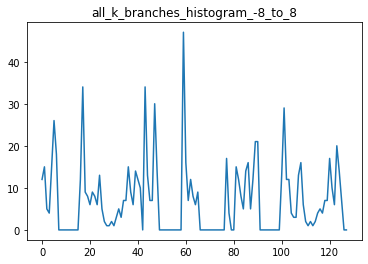

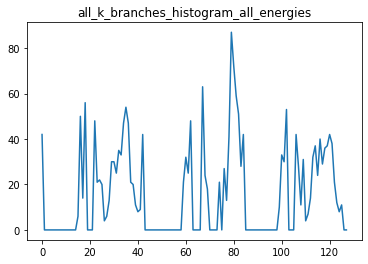

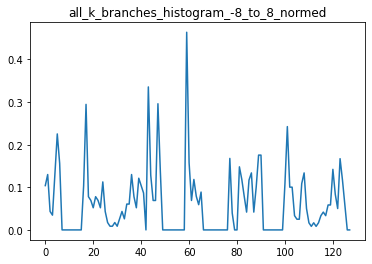

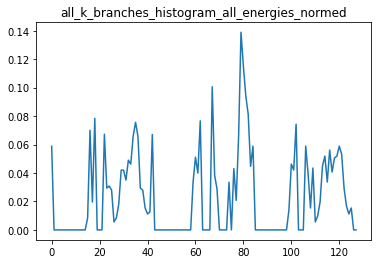

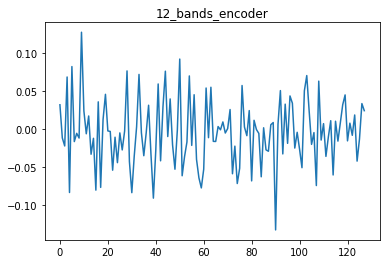

In [24]:
fingerprint_functions = {
    "all_k_branches_histogram_-8_to_8": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=False),
    "all_k_branches_histogram_all_energies": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=False),
    "all_k_branches_histogram_-8_to_8_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=True),
    "all_k_branches_histogram_all_energies_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=True),
    "12_bands_encoder": lambda x: run_trained_model_one_mat(x, CNN_model=trained_model, input_band_image_type=CNN_input_file_index, width=WIDTH)
}

for fingerprint_name in fingerprint_functions: 
    fp = fingerprint_functions[fingerprint_name]("2dm-1")
    plt.plot(fp)
    plt.title(fingerprint_name)
    plt.show()
    

In [25]:
fingerprint_array = np.zeros([len(df_material), FINGERPRINT_LENGTH])

In [26]:
for i, material_id in enumerate(df_material.index):
    if i % 100 == 0:
        print(i, "/", len(df_material))

    fingerprint_array[i, :] = fingerprint_functions[FINGERPRINT_NAME](material_id)

print(fingerprint_array)

0 / 5270
100 / 5270
200 / 5270
300 / 5270
400 / 5270
500 / 5270
600 / 5270
700 / 5270
800 / 5270
900 / 5270
1000 / 5270
1100 / 5270
1200 / 5270
1300 / 5270
1400 / 5270
1500 / 5270
1600 / 5270
1700 / 5270
1800 / 5270
1900 / 5270
2000 / 5270
2100 / 5270
2200 / 5270
2300 / 5270
2400 / 5270
2500 / 5270
2600 / 5270
2700 / 5270
2800 / 5270
2900 / 5270
3000 / 5270
3100 / 5270
3200 / 5270
3300 / 5270
3400 / 5270
3500 / 5270
3600 / 5270
3700 / 5270
3800 / 5270
3900 / 5270
4000 / 5270
4100 / 5270
4200 / 5270
4300 / 5270
4400 / 5270
4500 / 5270
4600 / 5270
4700 / 5270
4800 / 5270
4900 / 5270
5000 / 5270
5100 / 5270
5200 / 5270
[[ 0.03209126 -0.01173287 -0.02234737 ... -0.01309217  0.03367241
   0.02429434]
 [ 0.04118195 -0.01363583 -0.02324178 ... -0.00543796  0.01543805
   0.02696566]
 [ 0.03320226 -0.01386723 -0.02614455 ... -0.0079965   0.01729604
   0.02406   ]
 ...
 [ 0.03503917 -0.0145815  -0.02525602 ... -0.0072124   0.01608584
   0.02486758]
 [ 0.0362992  -0.01072095 -0.02808232 ... -0.01

In [27]:
#check for NaNs 
np.isnan(fingerprint_array).sum()

0

## Create T-SNE Reduced Dimension Fingerprints

In [28]:
tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=PERPLEXITY ,n_iter=10000, verbose=2)
fingerprint_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5270 samples in 0.001s...
[t-SNE] Computed neighbors for 5270 samples in 0.612s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5270
[t-SNE] Computed conditional probabilities for sample 2000 / 5270
[t-SNE] Computed conditional probabilities for sample 3000 / 5270
[t-SNE] Computed conditional probabilities for sample 4000 / 5270
[t-SNE] Computed conditional probabilities for sample 5000 / 5270
[t-SNE] Computed conditional probabilities for sample 5270 / 5270
[t-SNE] Mean sigma: 0.005554
[t-SNE] Computed conditional probabilities in 0.242s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 75.7572784, gradient norm = 0.0028537 (50 iterations in 2.063s)
[t-SNE] Iteration 100: error = 74.4330597, gradient norm = 0.0005884 (50 iterations in 1.969s)
[t-SNE] Iteration 150: error = 74.2530441, gradient norm = 0.0002223 (50 iterations in 2.011s)
[t-SNE] Iteration 200: error = 74.2133331, gradient norm = 0.0000870 (50 iterations in 2.127s)
[t-SNE] Iteration 250: error = 74.2032166, gradient norm = 0.0000432 (50 iterations in 1.945s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.203217
[t-SNE] Iteration 300: error = 2.2082725, gradient norm = 0.0016816 (50 iterations in 2.041s)
[t-SNE] Iteration 350: error = 1.7413007, gradient norm = 0.0007370 (50 iterations in 1.960s)
[t-SNE] Iteration 400: error = 1.5326868, gradient norm = 0.0004375 (50 iterations in 1.236s)
[t-SNE] Iteration 450: error = 1.4136726, gradient norm = 0.0002982 (50 iterations in 0.860s)
[t-SNE] Iteration 500: error = 1.3370414, gradient norm = 0.0002183 (50 

## Quick cluster (not saved) and plots to check fingerprint and T-SNE worked

In [29]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=3, p=0.2)
clusterer.fit(fingerprint_array)
labels = clusterer.labels_

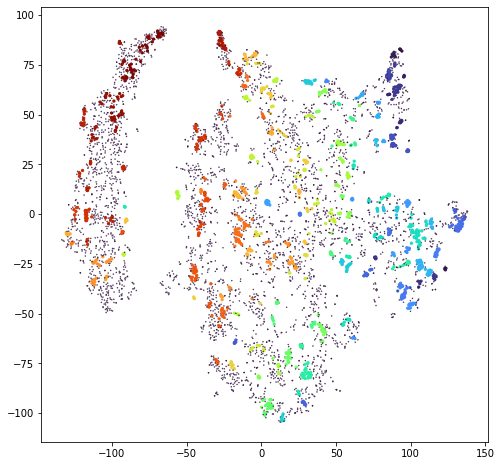

In [30]:
fig, ax  = plt.subplots(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

ax.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")

## Add fingerprints, T-SNE to dataframe

In [31]:
df = df_material.join(pd.DataFrame(fingerprint_array, index=df_material.index))
df["fx"] = fingerprint_2d[:, 0]
df["fy"] = fingerprint_2d[:, 1]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,120,121,122,123,124,125,126,127,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,-0.015605,0.007790,-0.008290,0.018606,-0.042381,-0.013092,0.033672,0.024294,39.140633,-87.381668
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,-0.015437,0.006228,-0.005140,0.027344,-0.031294,-0.005438,0.015438,0.026966,51.069729,35.376919
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,-0.017306,-0.001280,-0.000032,0.026500,-0.028387,-0.007997,0.017296,0.024060,-12.527380,-2.879488
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,-0.015034,0.002095,-0.000948,0.030945,-0.036810,-0.007320,0.020860,0.026485,-16.769491,-61.129993
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,-0.018107,0.001664,-0.005371,0.027124,-0.035880,-0.009893,0.024701,0.026193,40.190086,-75.894485


In [32]:
df.to_csv("../fingerprints/"+OUTPUT_NAME)

# View a predicted band 

NotImplementedError: Input Error: Only 3D, 4D and 5D input Tensors supported (got 2D) for the modes: nearest | linear | bilinear | bicubic | trilinear | area | nearest-exact (got nearest)

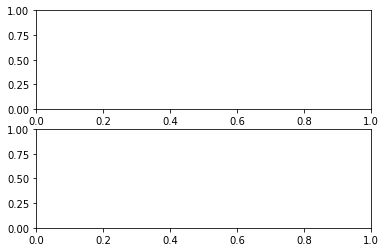

In [34]:

#from models import *

view_prediction("2dm-1979", trained_model.model, -17, 20, width=128)